In [3]:
#Notebook Setup

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.stats.multitest import fdrcorrection
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2,
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [4]:
df = pd.read_csv('log_ap_df.csv').rename(columns={'Unnamed: 0': 'gene'}).set_index('gene')

# during quality control we decided to remove samples tub1 and con1
wanted = [c for c in df.columns if ('tub1' not in c) & ('con1' not in c)]
df = df[wanted]
df = df[(df > 0.5).sum(axis=1) > 5]
df.head()

,con2A,con2P,con4A,con4P,con5A,con5P,tub2A,tub2P,tub3A,tub3P,tub4A,tub4P,tub5A,tub5P
gene,,,,,,,,,,,,,,
SteCoe_1,4.862229,5.083837,5.067023,4.794471,5.159237,4.678247,4.948243,4.704319,4.446902,4.385588,4.280728,4.336849,4.387184,4.150624
SteCoe_10,3.310267,3.557339,3.392957,3.338245,3.079831,3.272346,3.250539,3.426690,3.275349,3.249149,3.441771,3.629246,3.616664,3.561797
SteCoe_100,0.448487,0.950953,0.798218,0.658658,0.697524,0.677687,0.821407,1.071005,1.042232,0.805663,0.996761,0.724791,0.872272,0.880112
SteCoe_1000,3.210635,3.615015,3.176114,3.390179,3.381500,3.083633,3.921269,3.952004,3.869610,4.036804,4.077154,3.725640,3.637402,3.677309
SteCoe_10002,2.642902,3.197424,3.453061,3.314831,3.312158,3.207587,2.994912,3.360969,3.365353,3.120192,3.477802,3.389040,3.553889,3.819785


### Skew Analysis

([<matplotlib.axis.YTick at 0x7fc05a198fa0>,
 <a list of 4 Text major ticklabel objects>)

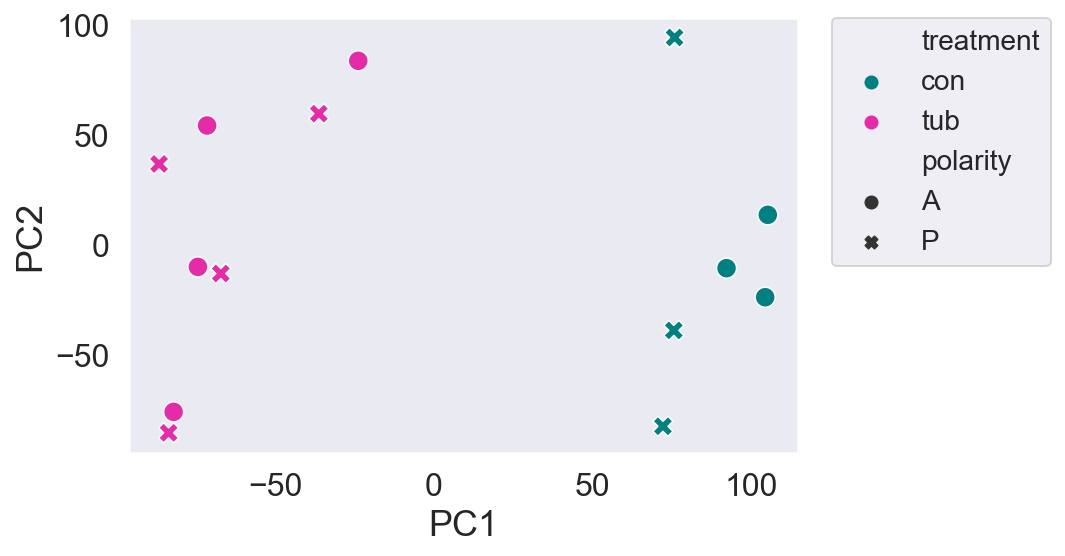

In [5]:
# compute pca:
pca = PCA(2)

# SS().fit_transform scales the data so mean per gene is 0, and std per gene = 1
# pca.fit_transform computes pca to 2 components
coords = pca.fit_transform(SS().fit_transform(df.T))

# get coordinates into a nice dataframe
pc = pd.DataFrame(coords, index=df.columns, columns=['PC1', 'PC2'])

# annotate metadata:
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.scatterplot('PC1', 'PC2', hue='treatment', palette = ('#008080','#E62BA9'), data=pc, style = 'polarity', s = 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks([-50, 0, 50, 100])
plt.yticks([-50, 0, 50, 100])
plt.savefig('PCA_conditions.png', bbox_inches='tight', dpi = 300)

([<matplotlib.axis.YTick at 0x7fc088b9bd60>,
 <a list of 4 Text major ticklabel objects>)

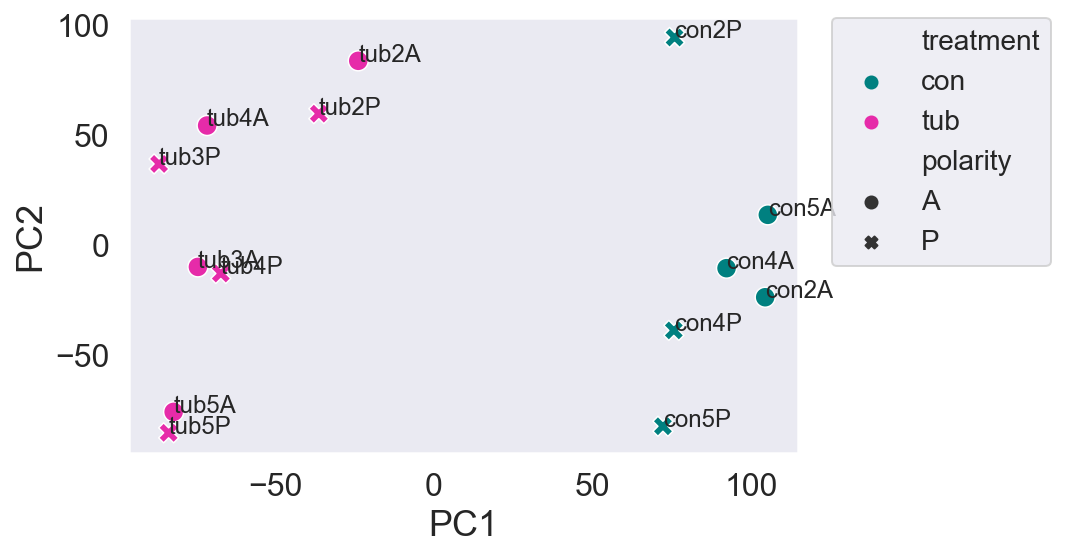

In [6]:
# same plot, samples labeled 

sns.scatterplot('PC1', 'PC2', hue='treatment', palette = ('#008080','#E62BA9'), data=pc, style = 'polarity', s = 100)
for sample in pc.index:
    s = pc.reindex([sample])
    plt.annotate(sample, (s.PC1, s.PC2))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks([-50, 0, 50, 100])
plt.yticks([-50, 0, 50, 100])

In [7]:
# cast the dataframe from matrix shape into tidy format
tidy = df.reset_index()\
         .melt(id_vars='gene', var_name='Sample', value_name='log1TPM') 
# annotate metadata:
tidy['treatment'] = tidy.Sample.str[:3]
tidy['Cell_ID'] = tidy.Sample.str[:4]
tidy['Polarity'] = tidy.Sample.str[-1]
tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity
0,SteCoe_1,con2A,4.862229,con,con2,A
1,SteCoe_10,con2A,3.310267,con,con2,A
2,SteCoe_100,con2A,0.448487,con,con2,A
3,SteCoe_1000,con2A,3.210635,con,con2,A
4,SteCoe_10002,con2A,2.642902,con,con2,A


In [8]:
# compute mean log1TPM per sample
tidy['sample_mean_log1TPM'] = tidy.groupby('Sample').log1TPM.transform(np.mean).values

# compute a "regularized" log1TPM, which is equal to log1TPM + mean log1TPM for that sample
tidy['log1RPM'] = tidy.log1TPM + tidy.sample_mean_log1TPM

tidy.head()

,gene,Sample,log1TPM,treatment,Cell_ID,Polarity,sample_mean_log1TPM,log1RPM
0,SteCoe_1,con2A,4.862229,con,con2,A,2.046958,6.909187
1,SteCoe_10,con2A,3.310267,con,con2,A,2.046958,5.357225
2,SteCoe_100,con2A,0.448487,con,con2,A,2.046958,2.495445
3,SteCoe_1000,con2A,3.210635,con,con2,A,2.046958,5.257593
4,SteCoe_10002,con2A,2.642902,con,con2,A,2.046958,4.689860


In [9]:
# split tidy dataframe into two, A and P dataframes
atidy = tidy[tidy.Polarity == 'A'].set_index(['gene', 'Cell_ID'])
ptidy = tidy[tidy.Polarity == 'P'].set_index(['gene', 'Cell_ID'])

# stack the two tidy dataframes so that A and P from the same cell are side by side
stack = atidy.join(ptidy[['log1RPM', 'sample_mean_log1TPM']], rsuffix=('_posterior'))
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior
gene,Cell_ID,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242


In [10]:
# compute skew as regularized Delta / regularized Total counts
stack['Skew'] = ((stack.log1RPM - stack.log1RPM_posterior) /
                 (stack.log1RPM + stack.log1RPM_posterior))

stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew
gene,Cell_ID,,,,,,,,,
SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541
SteCoe_10,con2,con2A,3.310267,con,A,2.046958,5.357225,5.586581,2.029242,-0.020958
SteCoe_100,con2,con2A,0.448487,con,A,2.046958,2.495445,2.980195,2.029242,-0.088528
SteCoe_1000,con2,con2A,3.210635,con,A,2.046958,5.257593,5.644257,2.029242,-0.035468
SteCoe_10002,con2,con2A,2.642902,con,A,2.046958,4.689860,5.226666,2.029242,-0.054133


<ipython-input-13-19565e45b719>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_skews = stack.reset_index()\


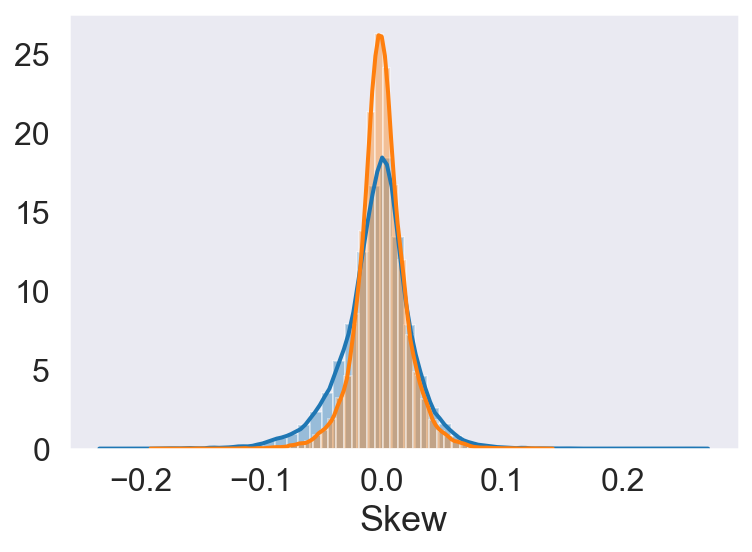

In [13]:
# visualize a histogram of mean skews.
mean_skews = stack.reset_index()\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()

mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2
sns.distplot(mean_skews[mean_skews.treatment == 'con'].Skew)
sns.distplot(mean_skews[mean_skews.treatment == 'tub'].Skew)

Text(0.5, 1.0, 'Skew')

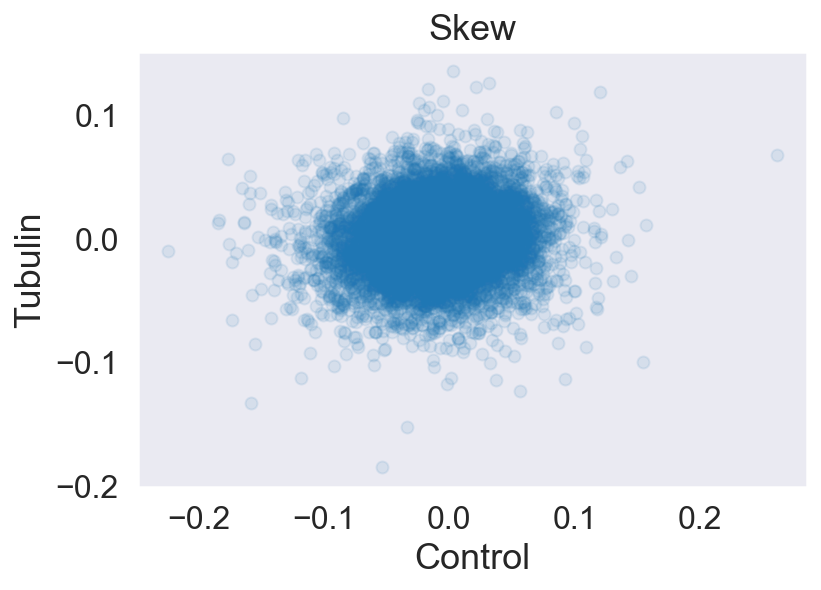

In [14]:
# plot mean skews in control vs tubulin
cond = lambda x: mean_skews.treatment == x
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha=0.1)

plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.title('Skew')

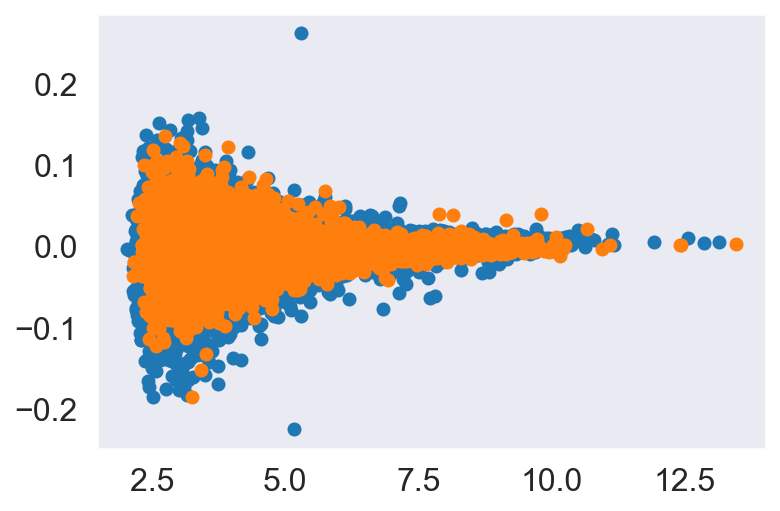

In [17]:
# mean vs skew plots
plt.scatter(mean_skews[cond('con')].mean_log1RPM, mean_skews[cond('con')].Skew)
plt.scatter(mean_skews[cond('tub')].mean_log1RPM, mean_skews[cond('tub')].Skew)

25322


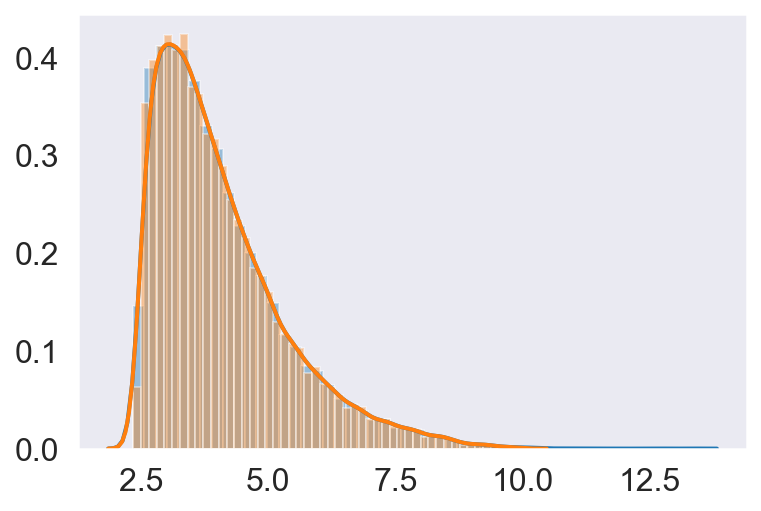

In [18]:
# make sure RPMs are within a reasonable range:
mean_rpm = stack.groupby('gene')[['log1RPM_posterior', 'log1RPM']].mean().mean(axis=1)
wanted = mean_rpm[mean_rpm.between(2, 10)].index
print(len(wanted))
sns.distplot(mean_rpm)
sns.distplot(mean_rpm[mean_rpm.between(2, 10)])

In [19]:
# compute coefficient of variation(std / mean) so we don't test things that are
# so variable that they would never be stat sig differentially expressed
# therefore reducing our FDR penalty

stack = stack.reset_index()[stack.reset_index().gene.isin(wanted)]
stack['coeff'] = stack.groupby(['gene', 'treatment']).Skew\
                            .transform(lambda x: np.std(x) / np.abs(np.mean(x)))
stack.sort_values(['gene', 'Cell_ID'], inplace=True)
stack.head()

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff
0,SteCoe_1,con2,con2A,4.862229,con,A,2.046958,6.909187,7.113079,2.029242,-0.014541,1.618032
25339,SteCoe_1,con4,con4A,5.067023,con,A,2.005359,7.072382,6.803104,2.008634,0.019407,1.618032
50678,SteCoe_1,con5,con5A,5.159237,con,A,2.006640,7.165877,6.736237,2.057990,0.030905,1.618032
76017,SteCoe_1,tub2,tub2A,4.948243,tub,A,2.050640,6.998883,6.747187,2.042867,0.018310,1.051115
101356,SteCoe_1,tub3,tub3A,4.446902,tub,A,2.052930,6.499831,6.437725,2.052137,0.004800,1.051115


Text(0.5, 0, 'log(Coefficent of Variation)')

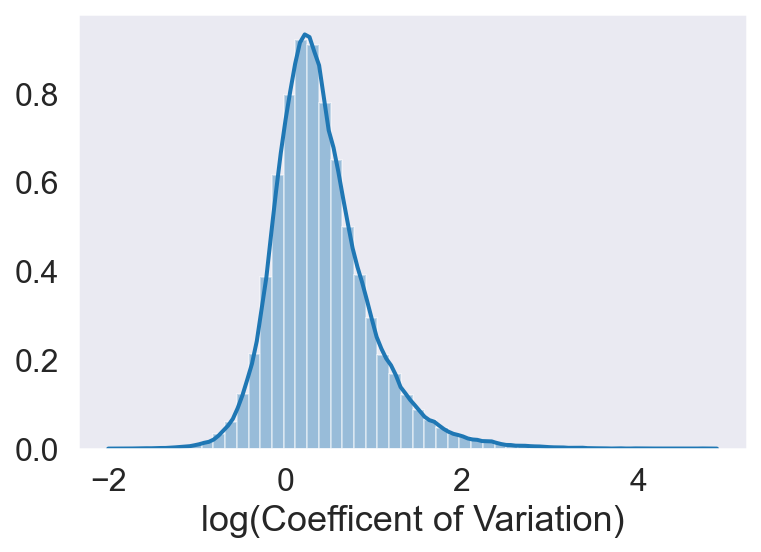

In [20]:
sns.distplot(stack.coeff.apply(np.log10))
plt.xlabel('log(Coefficent of Variation)')

In [21]:
# remove genes where the coefficient of variation is >2 
stack = stack[stack.coeff < 2]

# find genes that are present in tub and control, cause the above line may have broken that
sel = (stack.groupby('gene').treatment.count() == 7)
wanted = stack.groupby('gene').treatment.count()[sel].index
stack = stack[stack.gene.isin(wanted)]
len(stack.gene.unique())

5853

<ipython-input-22-937269c3e197>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_skews = stack\


Text(0.5, 1.0, 'Skew')

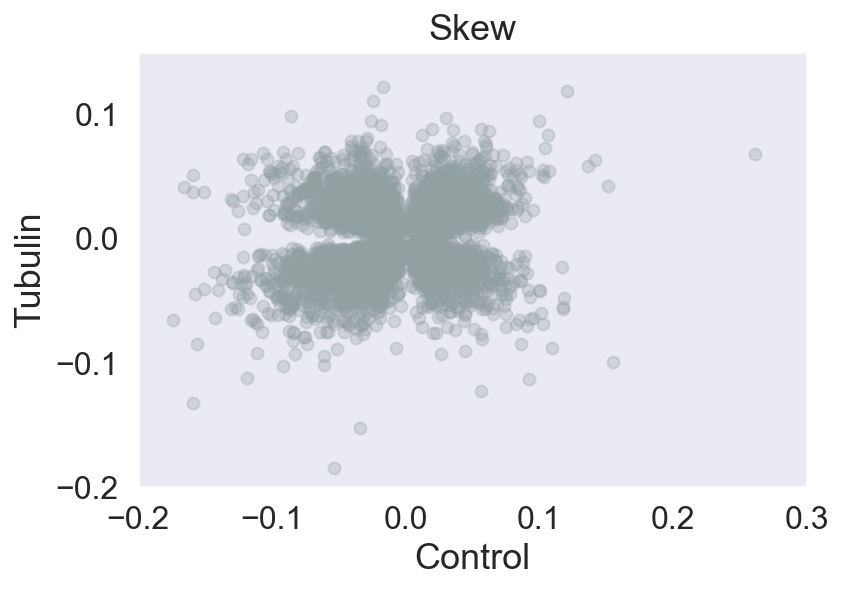

In [22]:
# recompute mean skews
mean_skews = stack\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()
#mean_skews = mean_skews.join(pvals.sig, on='gene')

cond = lambda x: (mean_skews.treatment == x)
mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2


# plot tubulin vs control skews. Now the plot will not look like an oval,
# mainly because we removed lots of things that were low expression, or that had
# poor fano factors
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha = 0.3, color= '#92A0A2')

plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.xlim(-0.2,0.3)
plt.ylim(-0.2,0.15)
plt.title('Skew')

# the plot below looks like a butterfly
# the correlated arm are likely genes where the KD did not have
# a strong effect on rna localization
# the anticorrelated arm are genes that switched their localization
# upon KD of tubulin

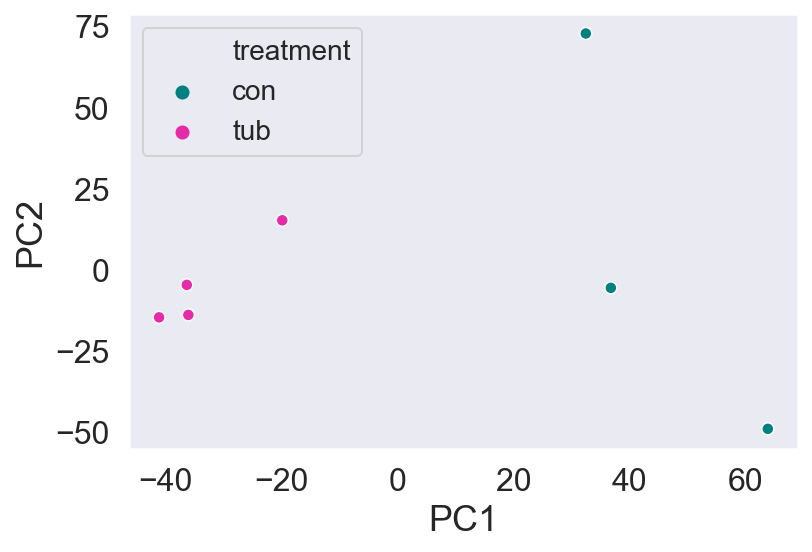

In [23]:
# next, use PCA to select genes that are likely to have a sig skew value so that we only test those
x = stack.pivot(index='gene', columns='Sample', values='Skew')

pca = PCA(2)
coords = pca.fit_transform(SS().fit_transform(x.T))
pc = pd.DataFrame(coords, index=x.columns, columns=['PC1', 'PC2'])
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.scatterplot('PC1', 'PC2', hue='treatment', data=pc, palette = ('#008080','#E62BA9'))
wanted = x.index[np.argsort(np.abs(pca.components_[0]))[-500:]]

stack = stack[stack.gene.isin(wanted)]

In [24]:
# do a t-test for statistical significance
PV = []
G = []
for gene, group in stack.reset_index()[stack.reset_index().gene.isin(wanted)].groupby('gene'):
    npolar = group[group.treatment == 'tub'].Skew
    polar = group[group.treatment == 'con'].Skew
    t, p = scipy.stats.ttest_ind(npolar, polar, equal_var=False)
    PV += [p]
    G += [gene]
    
# store results in a dataframe:
pvals = pd.DataFrame([PV, G], index=['p_value', 'gene']).T.set_index('gene')
pvals['q_value'] = fdrcorrection(pvals.p_value.values)[1]
pvals['sig'] = (pvals.q_value < 0.1).values
pvals.head()

,p_value,q_value,sig
gene,,,
SteCoe_10036,0.0675403,0.09433,True
SteCoe_10062,0.0356142,0.0738065,True
SteCoe_10386,0.109563,0.12369,False
SteCoe_10500,0.0318864,0.0707138,True
SteCoe_1084,0.0609282,0.0888875,True


In [25]:
# append results to our master "stack" dataframe:
stack = stack.join(pvals, on='gene')

<ipython-input-26-4afe4ba8b76b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_skews = stack\


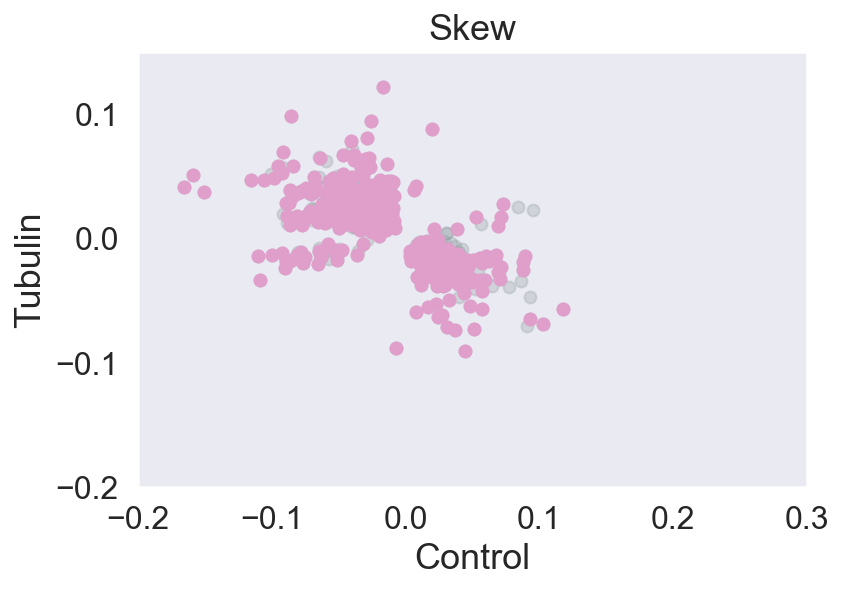

In [26]:
# recompute mean skews
mean_skews = stack\
                  .groupby(['treatment', 'gene'])['log1RPM', 'log1RPM_posterior', 'Skew']\
                  .mean()\
                  .reset_index()
mean_skews = mean_skews.join(pvals.sig, on='gene')

cond = lambda x: (mean_skews.treatment == x)
mean_skews['mean_log1RPM'] = (mean_skews.log1RPM + mean_skews.log1RPM_posterior) / 2


# plot tubulin vs control skews. Now the plot will not look like an oval,
# mainly because we removed lots of things that were low expression, or that had
# poor fano factors
plt.scatter(mean_skews[cond('con')].Skew, mean_skews[cond('tub')].Skew, alpha = 0.3, color= '#92A0A2')
plt.scatter(mean_skews[cond('con') & (mean_skews.sig == True)].Skew,
            mean_skews[cond('tub') & (mean_skews.sig == True)].Skew, color='#E09FCB')
plt.xlabel('Control')
plt.ylabel('Tubulin')
plt.xlim(-0.2,0.3)
plt.ylim(-0.2,0.15)
plt.title('Skew')
plt.savefig('significant_skew.png', bbox_inches='tight', dpi = 300)
# the plot below looks like a butterfly
# the correlated arm are likely genes where the KD did not have
# a strong effect on rna localization
# the anticorrelated arm are genes that switched their localization
# upon KD of tubulin

In [27]:
# most interesting genes are likely anticorrelated
# switch the mean_skews matrix from tidy format into matrix format,
# where genes are rows, and there are two columns, control and treatment
skew_mat = mean_skews.pivot(index='gene', columns='treatment', values='Skew')
# select things that are anticorrelated
#(anticorrelated genes have opposing signs) in tubulin and control
anticorr = skew_mat[skew_mat.con * skew_mat.tub < 0].index

# select anticorrelated genes between tub and control, that are sig in qval
# and for tidyness select just controls
select = ((mean_skews.gene.isin(anticorr)) &
          (mean_skews.sig) &
          (mean_skews.treatment == 'con'))
        
mean_skews[select].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM
375,con,SteCoe_35013,2.019652,2.821557,-0.165133,True,2.420604
11,con,SteCoe_11319,2.960104,4.039403,-0.158769,True,3.499753
386,con,SteCoe_36057,2.601449,3.519104,-0.150664,True,3.060276
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194
479,con,SteCoe_9126,2.780742,3.433139,-0.105791,True,3.106940
...,...,...,...,...,...,...,...
385,con,SteCoe_35890,3.643706,3.069293,0.088087,True,3.356499
102,con,SteCoe_16525,3.127036,2.605478,0.089524,True,2.866257
21,con,SteCoe_11625,4.324349,3.601348,0.093127,True,3.962848
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256


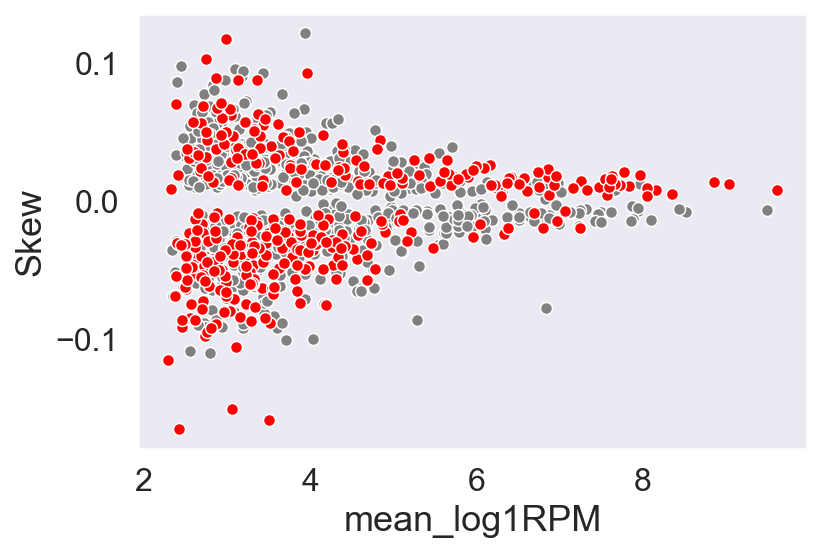

In [28]:
# MA plot showing how low or high regularized expression these genes have:
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews, color='gray')
sns.scatterplot('mean_log1RPM', 'Skew', data=mean_skews[select], color='red')

In [29]:
# compute the transcriptome wide skew per sample:
avg_skew = ((stack.sample_mean_log1TPM - stack.sample_mean_log1TPM_posterior) /
            (stack.sample_mean_log1TPM + stack.sample_mean_log1TPM_posterior))
stack['avg_skew_treatment'] = avg_skew

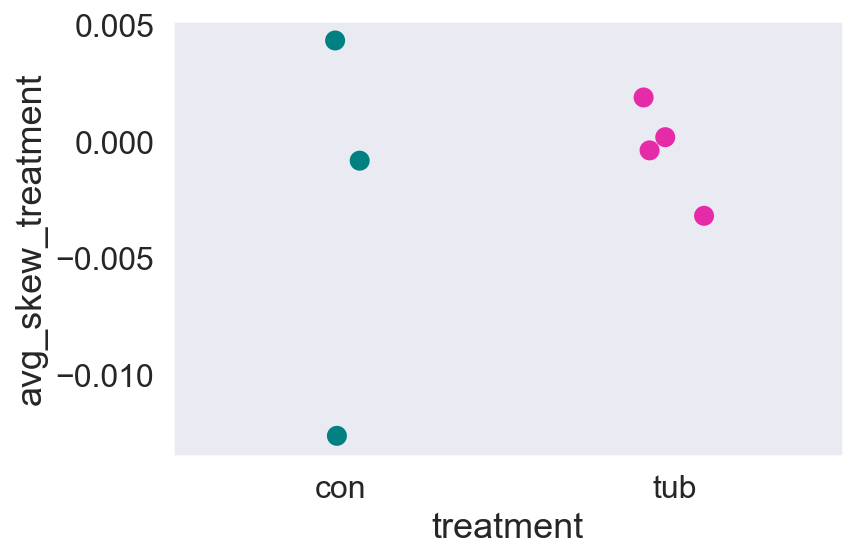

In [30]:
# for each sample, plot the transcriptome-wide skew:
sns.stripplot('treatment', 'avg_skew_treatment',
              data=stack[['treatment', 'avg_skew_treatment']].drop_duplicates(), palette = ('#008080','#E62BA9'), s = 10)
plt.savefig('avg_skew.png', bbox_inches='tight', dpi = 300)

In [31]:
# compute the mean transcriptome-wide skews for control and tubulin
# and then compute the difference of means between both conditions
# this is the smallest believable "skew"
stack[['treatment', 'avg_skew_treatment']]\
    .drop_duplicates()\
    .groupby('treatment')\
    .mean()\
    .diff()\
    .dropna()

,avg_skew_treatment
treatment,
tub,0.002668


In [32]:
# the above line tells you what difference is probably the smallest difference
# you should ever believe in skew

In [66]:
# make sure skews are > 0.0027
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

<ipython-input-66-f5557194564f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')


,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
375,con,SteCoe_35013,2.019652,2.821557,-0.165133,True,2.420604,hypothetical protein
11,con,SteCoe_11319,2.960104,4.039403,-0.158769,True,3.499753,hypothetical protein
386,con,SteCoe_36057,2.601449,3.519104,-0.150664,True,3.060276,hypothetical protein
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194,zf-LITAF-like domain protein
479,con,SteCoe_9126,2.780742,3.433139,-0.105791,True,3.106940,hypothetical protein
...,...,...,...,...,...,...,...,...
385,con,SteCoe_35890,3.643706,3.069293,0.088087,True,3.356499,hypothetical protein
102,con,SteCoe_16525,3.127036,2.605478,0.089524,True,2.866257,hypothetical protein
21,con,SteCoe_11625,4.324349,3.601348,0.093127,True,3.962848,hypothetical protein
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256,Cystatin domain protein


In [67]:
mean_skews.to_csv('346candidates.csv')

### Candidate Analysis 

In [34]:
# load protein domain information 

x = []
y = []
with open('S_coeruleus_Nov2017_proteins.fasta') as f:
    lines = f.readlines()
    for l in lines:
        if '>' in l:
            line = l.split('\t')
            gene = line[0][1:]
            domain = line[1].strip()
            x += [gene]
            y += [domain]

prot_data = pd.DataFrame([x, y], index=['gene', 'domain']).T.set_index('gene')

In [35]:
# append domain information to mean_skews dataframe
mean_skews = mean_skews.join(prot_data, on='gene')

In [36]:
mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
375,con,SteCoe_35013,2.019652,2.821557,-0.165133,True,2.420604,hypothetical protein
11,con,SteCoe_11319,2.960104,4.039403,-0.158769,True,3.499753,hypothetical protein
386,con,SteCoe_36057,2.601449,3.519104,-0.150664,True,3.060276,hypothetical protein
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194,zf-LITAF-like domain protein
479,con,SteCoe_9126,2.780742,3.433139,-0.105791,True,3.106940,hypothetical protein
...,...,...,...,...,...,...,...,...
385,con,SteCoe_35890,3.643706,3.069293,0.088087,True,3.356499,hypothetical protein
102,con,SteCoe_16525,3.127036,2.605478,0.089524,True,2.866257,hypothetical protein
21,con,SteCoe_11625,4.324349,3.601348,0.093127,True,3.962848,hypothetical protein
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256,Cystatin domain protein


In [56]:
mean_skews = mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew')

In [61]:
# pick out top 10 greatest negative skew (more posterior) ignoring hypothetical proteins
topnegative = mean_skews[~mean_skews.domain.str.contains('hypothetical protein')].head(10)
topnegative.to_csv('top10negativeskew.csv')

topnegative

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
248,con,SteCoe_26054,2.019652,2.560736,-0.115558,True,2.290194,zf-LITAF-like domain protein
273,con,SteCoe_27980,2.499556,3.024413,-0.094826,True,2.761984,CLN3 domain protein
0,con,SteCoe_10036,2.229674,2.676440,-0.091622,True,2.453057,CK1 kinase
125,con,SteCoe_17481,2.609509,3.118044,-0.089260,True,2.863776,CDPK-like predicted pseudokinase
62,con,SteCoe_14494,3.200142,3.823725,-0.088666,True,3.511933,zf-RING_2 domain protein
197,con,SteCoe_22865,2.996976,3.577724,-0.086571,True,3.287350,TCR domain protein
451,con,SteCoe_6843,2.389678,2.834874,-0.086089,True,2.612276,ABC_tran domain protein
193,con,SteCoe_22502,2.251753,2.673160,-0.086038,True,2.462456,PX domain protein
461,con,SteCoe_7554,3.876725,4.505711,-0.075260,True,4.191218,Thioredoxin_8 domain protein
469,con,SteCoe_8635,2.374380,2.753981,-0.074449,True,2.564180,MFS_1 domain protein


In [63]:
# pick out top 10 greatest positive skew (more anterior) ignoring hypothetical protein
mean_skews = mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew', ascending = False)

toppositive = mean_skews[~mean_skews.domain.str.contains('hypothetical protein')].head(10)
toppositive.to_csv('top10positiveskew.csv')

toppositive

<ipython-input-63-13a4cc3be835>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_skews = mean_skews[(select) & (mean_skews.Skew.abs() > 0.0027)].sort_values('Skew', ascending = False)


,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
398,con,SteCoe_37198,3.019476,2.465037,0.102744,True,2.742256,Cystatin domain protein
210,con,SteCoe_23639,2.898078,2.515138,0.069203,True,2.706608,WD40 domain protein
412,con,SteCoe_3835,3.068671,2.689481,0.067467,True,2.879076,SBP_bac_3 domain protein
327,con,SteCoe_31769,3.243462,2.836166,0.066659,True,3.039814,kinase related to Ciliate-E2-Unclassified subf...
98,con,SteCoe_164,3.243746,2.858364,0.062174,True,3.051055,AMPK subfamily kinase
307,con,SteCoe_2990,3.664883,3.250722,0.059819,True,3.457803,STE related kinase
194,con,SteCoe_22530,3.394927,3.031318,0.057351,True,3.213123,TPR_2 domain protein
41,con,SteCoe_1329,2.837291,2.528796,0.057000,True,2.683043,RIH_assoc domain protein
433,con,SteCoe_4636,3.813916,3.423070,0.055607,True,3.618493,MAT1 domain protein
65,con,SteCoe_14610,3.625750,3.229900,0.055390,True,3.427825,CK_II_beta domain protein


In [49]:
# load supplementary table 2 from Lin et al 2022 
athena_csv = pd.read_csv('athenaS2genes.csv')

Lin et al 2022. Determining protein polarization proteome-wide using physical dissection of individual Stentor coeruleus cells https://doi.org/10.1016/j.cub.2022.03.078

Table S2 contains a list of genes corresponding to proteins that are enriched in the anterior OR posterior following bisection and proteomics

In [64]:
mean_skews[mean_skews.gene.isin(athena_csv.Protein)]

,treatment,gene,log1RPM,log1RPM_posterior,Skew,sig,mean_log1RPM,domain
212,con,SteCoe_23664,3.486939,3.294093,0.027629,True,3.390516,MORN domain protein
100,con,SteCoe_16433,6.325374,6.007144,0.025948,True,6.166259,Porin_3 domain protein
487,con,SteCoe_9485,9.151553,8.921360,0.012773,True,9.036457,Ldh_1_N domain protein
496,con,SteCoe_9878,5.022491,4.905743,0.011807,True,4.964117,GTP_EFTU domain protein
94,con,SteCoe_16150,5.496226,5.378302,0.011160,True,5.437264,Clat_adaptor_s domain protein


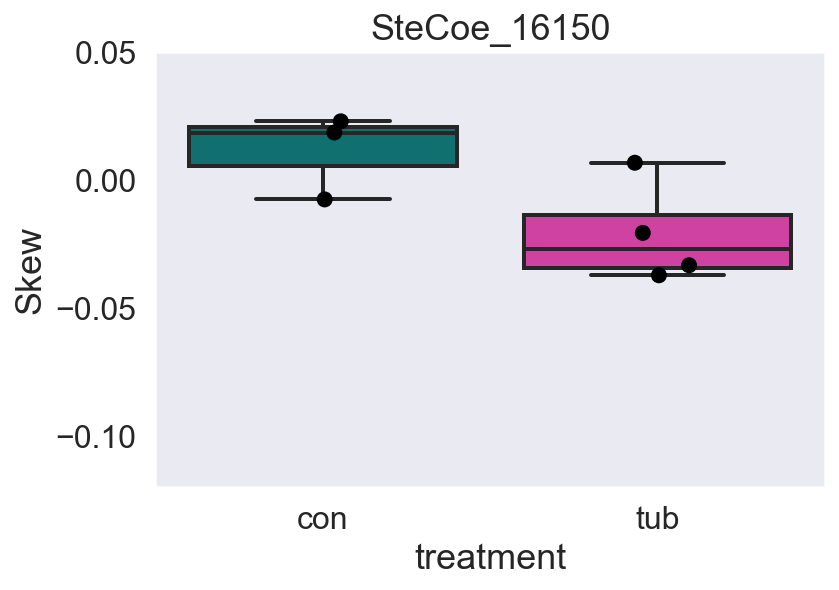

In [65]:
hit = "SteCoe_16150"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', palette = ('#008080','#E62BA9')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
plt.ylim(-0.12, 0.05)
plt.savefig('SteCoe_16150.png', bbox_inches='tight', dpi = 300)

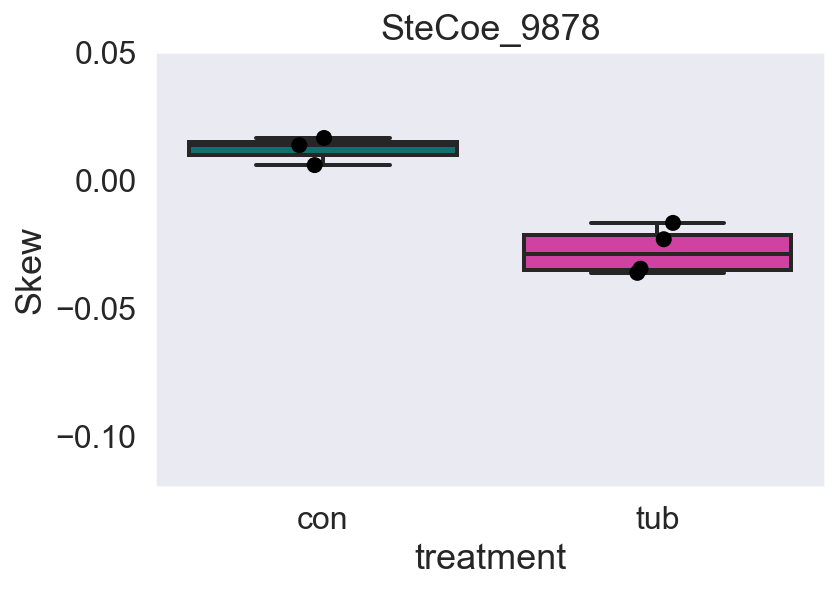

In [52]:
hit = "SteCoe_9878"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', palette = ('#008080','#E62BA9')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
plt.ylim(-0.12, 0.05)
plt.savefig('SteCoe_9878.png', bbox_inches='tight', dpi = 300)

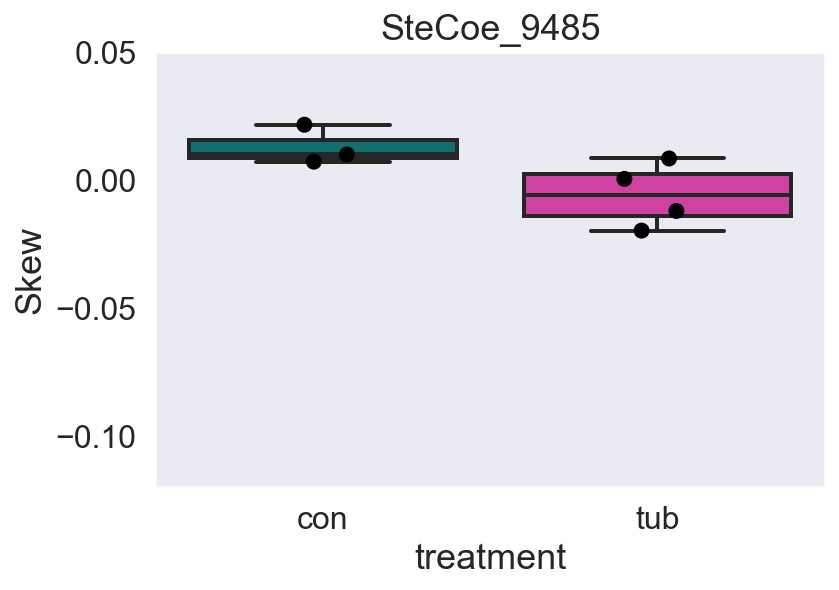

In [53]:
hit = "SteCoe_9485"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', palette = ('#008080','#E62BA9')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
plt.ylim(-0.12, 0.05)
plt.savefig('SteCoe_9485.png', bbox_inches='tight', dpi = 300)

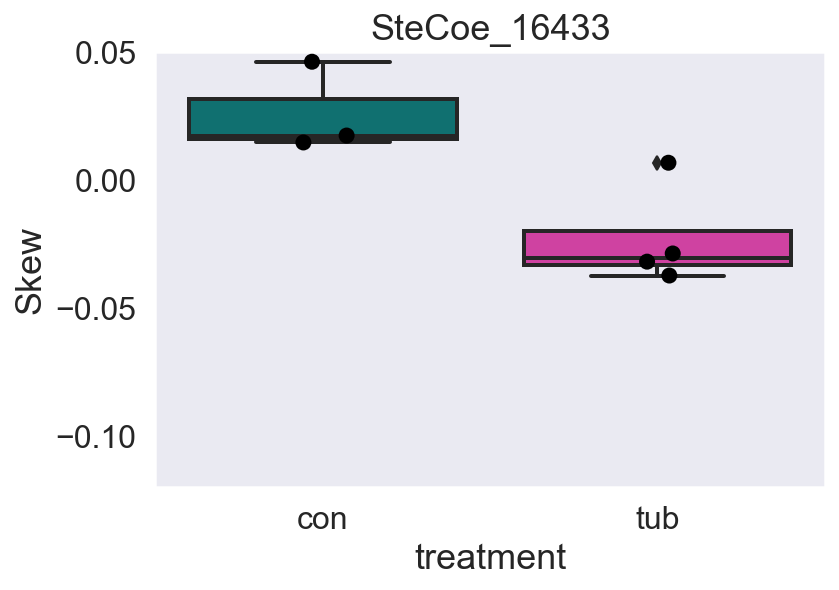

In [54]:
hit = "SteCoe_16433"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', palette = ('#008080','#E62BA9')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
plt.ylim(-0.12, 0.05)
plt.savefig('SteCoe_16433.png', bbox_inches='tight', dpi = 300)

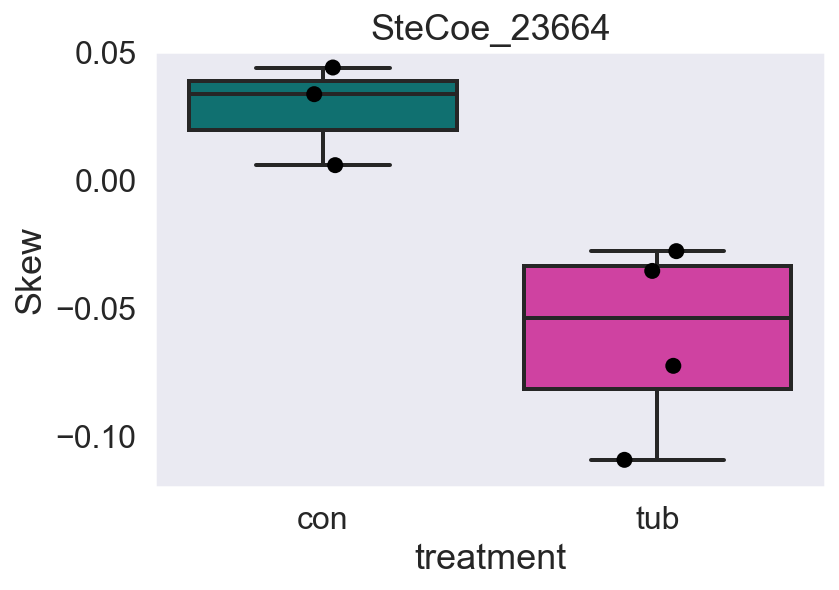

In [55]:
hit = "SteCoe_23664"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', palette = ('#008080','#E62BA9')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
plt.ylim(-0.12, 0.05)
plt.savefig('SteCoe_23664.png', bbox_inches='tight', dpi = 300)